<a href="https://colab.research.google.com/github/holehouse-lab/ALBATROSS-colab/blob/main/example_notebooks/polymer_property_predictors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to ALBATROSS-Colab - The IDR Ensemble Predictor
### Notebook version 1.0.3

![logo_v1](https://user-images.githubusercontent.com/71458933/236352540-c11d5076-1346-4cfb-8649-092f6c7c1485.png)

**ALBATROSS**; **A** deep-**L**earning **B**ased **A**pproach for predic**T**ing p**R**operties **O**f di**S**ordered protein**S**

An easy to use predictor for conformational ensembles of disordered proteins.

For more details please refer to our preprint [here](https://www.biorxiv.org/content/10.1101/2023.05.08.539824v3)



# Instructions:

**Quickstart**

*   Enter a sequence into the `sequence` box or upload a FASTA file of protein sequences from your computer.
*   Select the properties you'd like to generate predictions for
*   Select `Runtime` and press `Run all`
*   Profit.


Troubleshooting


*   To leverage GPUs for bulk FASTA file predictions, Check that the runtime type is set to GPU by clicking on the`Runtime` dropdown menu and change the runtime type by selecting `Change runtime type` to work with GPUs.
*   If GPU support is still not working, please try clicking `Runtime` -> `Restart Runtime`.


Limitations:

*   ALBATROSS was trained on simulations of disordered proteins with the coarse-grained force field Mpipi-GG. While Mpipi-GG shows **strong** correlation with experiments, predictions generated by ALBATROSS are limited by the resolution of the underlying force field - i.e., true ensemble dimensions will vary from ALBATROSS predictions for proteins containing secondary structure.






In [ ]:
#@title Install Necessary Dependencies
# !pip install git+https://git@github.com/idptools/parrot --quiet;
# !pip install git+https://git@github.com/idptools/sparrow.git --quiet;

!pip install idptools-parrot --quiet;
!pip install git+https://git@github.com/idptools/sparrow.git --quiet;


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.7/476.7 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 69.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.5 MB/s eta 0:00:00


In [ ]:
#@title File Imports
import sparrow
from sparrow.predictors.batch_predict import batch_predict
from google.colab import data_table
import pandas as pd
from sparrow.sparrow_exceptions import SparrowException

# plotting stuff
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from google.colab import files
import io
import os
from collections import defaultdict
import torch
import numpy as np


# Some plotting formatting stuff for mpl
# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}


data_table._DEFAULT_FORMATTERS[float] = lambda x: f"{x:.3f}"
# set so we can show whole human IDRome...
pd.set_option('display.max_rows', 40000)


Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


In [ ]:
#@title Target Sequence
#@markdown <h1>Enter the primary amino acid sequence:</h1>

#@markdown Notes:

#@markdown - The following predictors implicitly assume this sequence is disordered.

#@markdown - A sequence cannot be provided at the same time as a fasta file.

# define the function that will be called when the form is submitted
def process_form():
    uploaded_data = files.upload()
    uploaded_fasta = list(uploaded_data.keys())[0]
    # Load protein objects
    try:
      protein_objs = sparrow.read_fasta(uploaded_fasta)
    except TypeError as e:
      print(f"Received TypeError: Perhaps you didn't upload a file?")
      raise e

    return protein_objs



sequence = "THISISANAMINAACIDSEQWENCE" #@param {type:"string"}
fasta_file = False #@param {type:"boolean"}


if fasta_file and len(sequence) > 0:
  raise SparrowException(f"Cannot specify both a sequence and a list of sequences from a fasta file simultaneously")

if fasta_file:
    protein_objs = process_form()
    for protein in protein_objs:
        if len(protein) > 750:
            raise SparrowException(f"Sequences longer than 750 residues are not currently supported."\
            "You entered a protein with length {len(protein)} residues")
else:
    if len(sequence) > 750:
        raise SparrowException(f"Sequences longer than 750 residues are not currently supported."\
            "You entered a protein with length {len(sequence)} residues")

    protein_objs = sparrow.Protein(sequence)


In [ ]:
#@title Sequence Property Prediction

#@markdown <h1>Please select the ensemble features you'd like to predict and then press the run cell button: </h1>

#@markdown Predictions can be run on CPU or GPU. Bulk predictions from fasta will be slower on CPU.

radius_of_gyration = True #@param {type:"boolean"}
end_to_end_distance = True #@param {type:"boolean"}
asphericity = True #@param {type:"boolean"}
scaling_exponent = True #@param {type:"boolean"}
prefactor = True #@param {type:"boolean"}


def __gpu_accelerated_fasta_predictions(protein_objs):

    dfs = []
    labels = {header : protein.sequence for header,protein in protein_objs.items()}
    lengths = {protein.sequence : int(len(protein)) for header, protein in protein_objs.items()}
    dfs.append(pd.DataFrame(list(labels.items()), columns=['fasta_header', 'sequence']))
    dfs.append(pd.DataFrame(list(lengths.items()), columns=['sequence', 'lengths']))
    if radius_of_gyration:
        radius_of_gyrations = batch_predict(protein_objs,return_seq2prediction=True,network="scaled_rg")
        dfs.append(pd.DataFrame(list(radius_of_gyrations.items()), columns=['sequence', 'radius_of_gyration']))

    if end_to_end_distance:
        end_to_end_distances = batch_predict(protein_objs,return_seq2prediction=True,network="scaled_re")
        dfs.append(pd.DataFrame(list(end_to_end_distances.items()), columns=['sequence', 'end_to_end_distance']))

    if scaling_exponent:
        scaling_exponents = batch_predict(protein_objs,return_seq2prediction=True,network="scaling_exponent")
        dfs.append(pd.DataFrame(list(scaling_exponents.items()), columns=['sequence', 'scaling_exponent']))

    if asphericity:
        asphericitys = batch_predict(protein_objs,return_seq2prediction=True,network="asphericity")
        dfs.append(pd.DataFrame(list(asphericitys.items()), columns=['sequence', 'asphericity']))

    if prefactor:
        prefactors = batch_predict(protein_objs,return_seq2prediction=True, network="prefactor")
        dfs.append(pd.DataFrame(list(prefactors.items()), columns=['sequence', 'prefactor']))

    merged_df = dfs[0]  # initialize merged_df with the first dataframe

    for df in dfs[1:]:  # iterate over the remaining dataframes
        # merge on 'key' column
        merged_df = pd.merge(merged_df, df, on='sequence')
        # move 'sequence' column to the end
        merged_df = merged_df[[col for col in merged_df.columns if col != 'sequence'] + ['sequence']]

    return merged_df

def __cpu_fasta_predictions(protein_objs):
    dimensions = defaultdict(dict)

    for i, (header, protein) in enumerate(protein_objs.items(), 1):
        dimensions[header].update({"length" : int(len(protein))})
        dimensions[header].update({"sequence" : protein.sequence})

        if radius_of_gyration:
            dimensions[header].update({"radius_of_gyration" : protein.predictor.radius_of_gyration()})

        if end_to_end_distance:
            dimensions[header].update({"end_to_end_distance" : protein.predictor.end_to_end_distance()})

        if scaling_exponent:
            dimensions[header].update({"scaling_exponent" : protein.predictor.scaling_exponent()})

        if asphericity:
            dimensions[header].update({"asphericity" : protein.predictor.asphericity()})

        if prefactor:
            dimensions[header].update({"prefactor" : protein.predictor.prefactor()})

    df = pd.DataFrame(dimensions).T
    df = df.rename_axis('fasta_header')
    df = df[[col for col in df.columns if col != 'sequence'] + ['sequence']]

    return df

def return_fasta_predictions(protein_objs):
    if torch.cuda.is_available():
        df = __gpu_accelerated_fasta_predictions(protein_objs)
    else:
        df = __cpu_fasta_predictions(protein_objs)

    return df

def return_individual_predictions(protein):
    dimensions = dict()
    col_names = ["sequence","length"]

    dimensions["sequence"] = protein.sequence,
    dimensions["length"] = int(len(protein))


    if radius_of_gyration:
        dimensions["radius_of_gyration"] = protein.predictor.radius_of_gyration()
        col_names.append("radius_of_gyration")

    if end_to_end_distance:
        dimensions["end_to_end_distance"] = protein.predictor.end_to_end_distance()
        col_names.append("end_to_end_distance")

    if scaling_exponent:
        dimensions["scaling_exponent"] = protein.predictor.scaling_exponent()
        col_names.append("scaling_exponent")

    if asphericity:
        dimensions["asphericity"] = np.round(protein.predictor.asphericity(),3)
        col_names.append("asphericity")

    if prefactor:
        dimensions["prefactor"] = protein.predictor.prefactor()
        col_names.append("prefactor")

    df = pd.DataFrame(dimensions,columns=col_names)

    return df

def is_iterable(obj):
    try:
        iter(obj)
        return True
    except TypeError:
        return False


if is_iterable(protein_objs):
    df = return_fasta_predictions(protein_objs)
else:
    df = return_individual_predictions(protein_objs)

df["sequence"] = df["sequence"].str.wrap(10)


prediction_table = data_table.DataTable(df,
                                        include_index=False,
                                        num_rows_per_page=10,)


display(prediction_table)


,sequence,length,radius_of_gyration,end_to_end_distance,scaling_exponent,asphericity,prefactor
0,THISISANAM\nINAACIDSEQ\nWENCE,25,12.871733,32.124577,0.549379,0.468,6.236956


In [ ]:
#@title Download the CSV file containing your predictions

#@markdown <h1>Name of the CSV file that you'd like to save</h1>

filename = "sequence.csv" #@param {type:"string"}

filename = os.path.splitext(filename)[0]

if filename:
    df.to_csv(f"{filename}.csv")

    files.download(f'{filename}.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

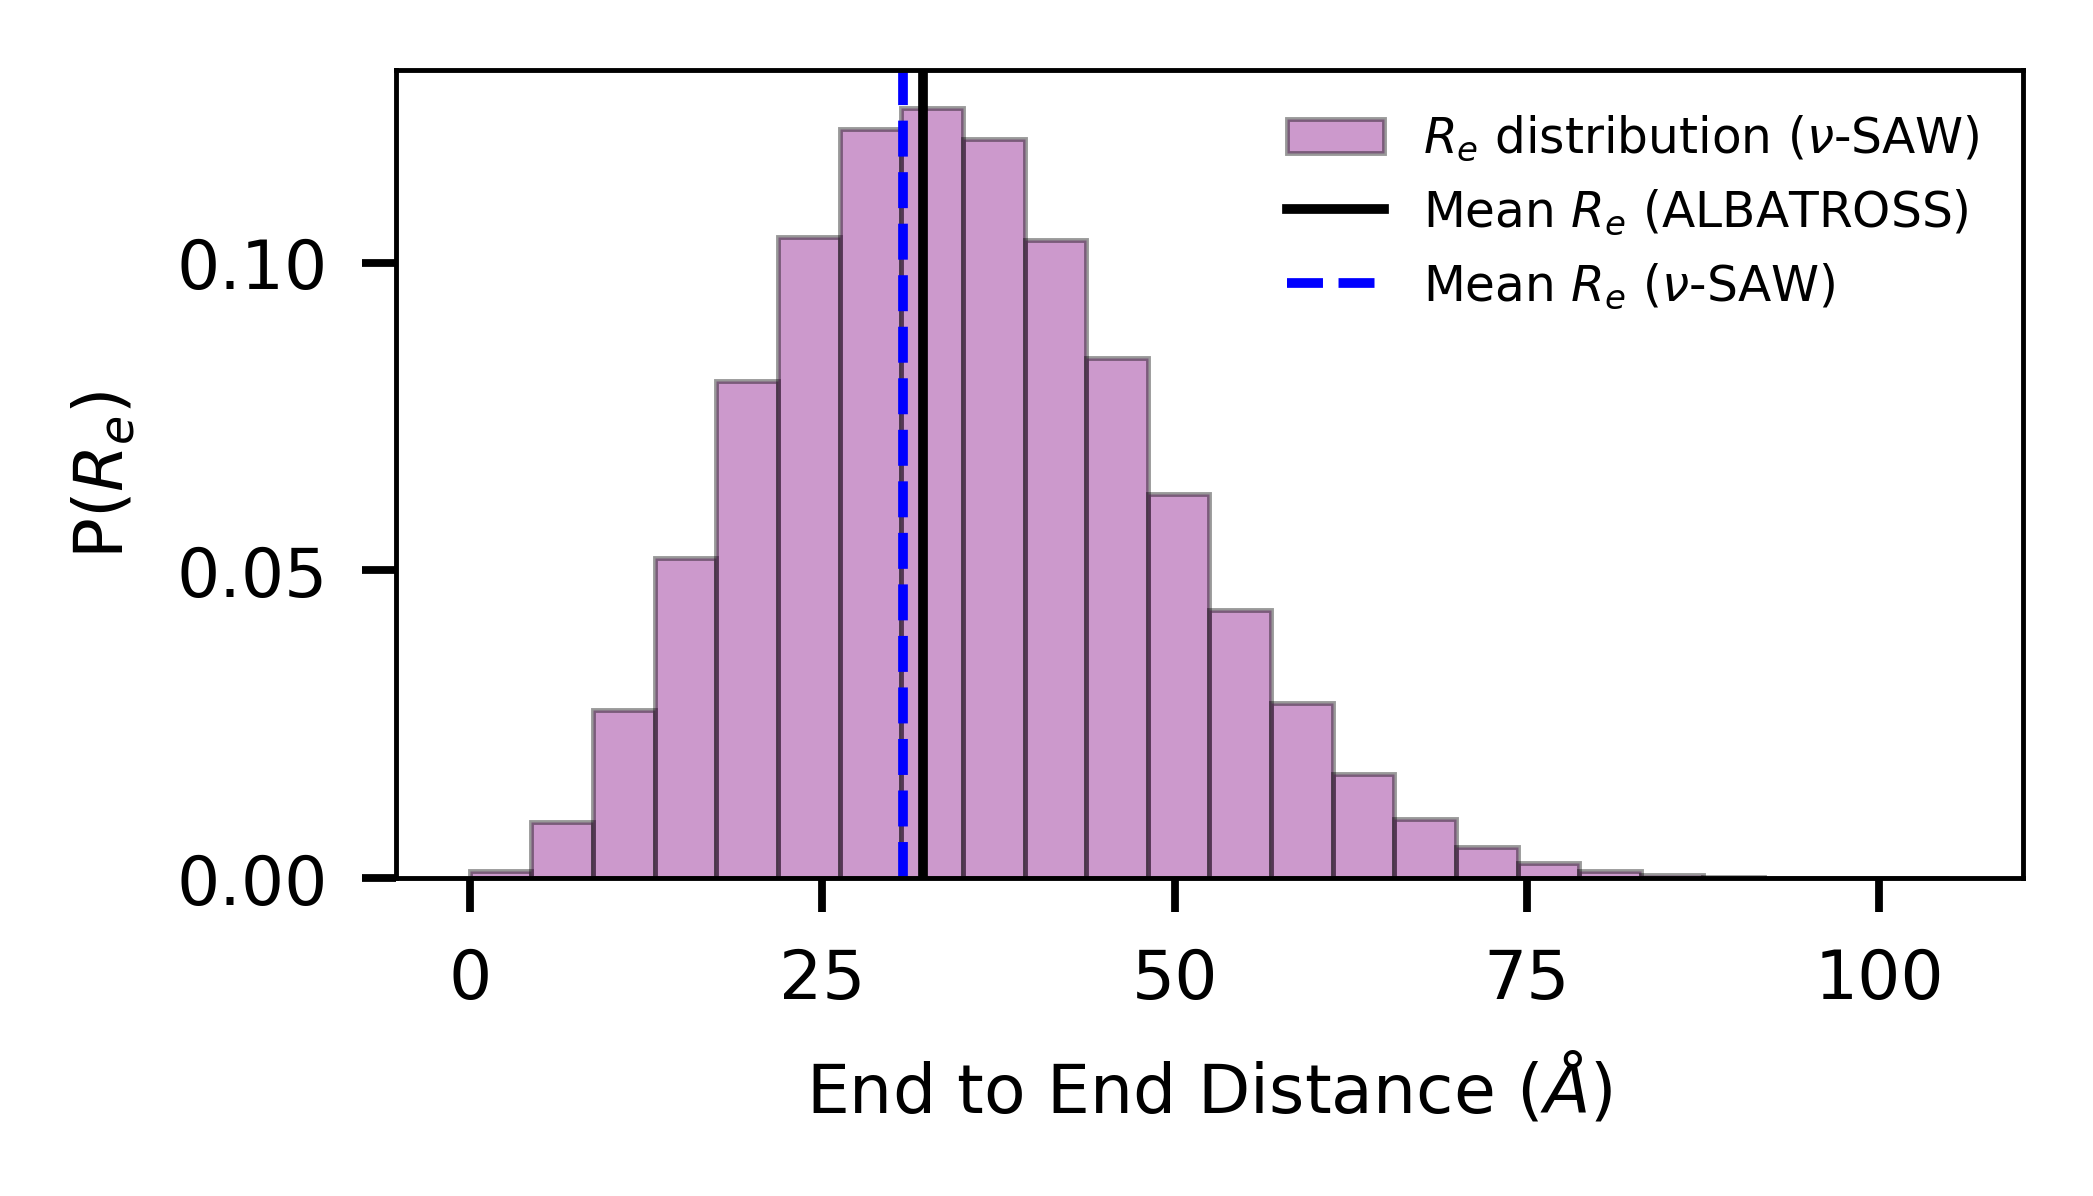

In [ ]:
#@title Plot predicted end-to-end-distribution

#@markdown <h2> This is currently an experimental feature.<h2>
#@markdown <h5> Briefly, we leverage ALBATROSS predictors to predict the scaling exponent and polymeric prefactor for a given sequence and use these predictions and the nu-dependent SAW model first established in [1], although we use an implementation derived in [2]. Predictions will work well for sequences with accurately predicted scaling exponents and where the assumptions defined in [1] and [2] hold.</h5>

fig = figure(None, (3,1.5), dpi=350)
bins = 24 #@param {type:"integer"}
if is_iterable(protein_objs):
    raise SparrowException("We don't currently support predicting end-to-end distance distributions from fasta files. Please use the single sequence method in the cell above.")

p_of_Re_R, p_of_Re_P = protein_objs.polymeric.get_predicted_nu_dep_end_to_end_distribution()
plt.hist(p_of_Re_R, weights=p_of_Re_P, linewidth=0.5, edgecolor='k',bins=bins, color='purple', alpha=0.4, label=r'$R_e$ distribution ($\nu$-SAW)')
plt.xlabel(r"End to End Distance ($\AA$)", fontsize=7)
plt.ylabel(r"P($R_e$)", fontsize=7)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

local_re_albatross = protein_objs.predictor.end_to_end_distance()
local_re_sawnu = protein_objs.polymeric.get_mean_nudep_saw_end_to_end_distance()

plt.axvline(local_re_albatross, linestyle="-",color='k',label=r"Mean $R_e$ (ALBATROSS)", linewidth=1)
plt.axvline(local_re_sawnu, linestyle="--",color='b',label=r"Mean $R_e$ ($\nu$-SAW)", linewidth=1)
if abs(local_re_albatross-local_re_sawnu) > 20:
    print('WARNING - looks like the the expected mean end-to-end distances are quite different. This may suggest the scaling exponent is poorly estimated and/or this sequence is poorly described as a flexible homopolymer')

plt.legend(frameon=False, fontsize=5)
plt.show()

# References

[1]   Zheng, W., Zerze, G. H., Borgia, A., Mittal, J., Schuler, B., & Best, R. B. (2018). Inferring properties of disordered chains from FRET transfer efficiencies. The Journal of Chemical Physics, 148(12), 123329.

[2]   Soranno, A. (2020). Physical basis of the disorder-order transition. Archives of Biochemistry and Biophysics, 685, 108305.



# Changelog

### 1.0.3
* Version 1.0.3 released (July 11th 2023)
* When requesting batch predictions for Radius of Gyration or End-to-end distances, this IDR property prediction notebook will use the scaled networks which showed improved performance for all sequence lengths. This ensures that the same networks are used for single sequence predictions and batch predictions. (see preprint for more details on scaled network training)

### 1.0.2
* Version 1.0.2 released (May 29th 2023)
* Fix batch predictions and update to ALBATROSS V2 (retraining / newest version of networks from v3 of ALBATROSS paper on bioarxiv)

### 1.0.1
* Version 1.0.1 released (May 8th 2023)
* Bug on GPU when batch size > 1 due to improper RNN sequence padding. Reduced the batch size on GPU to 1 while interim troubleshooting.

### 1.0
* Version 1.0 released (May 4th 2023)